In [1]:
import pandas as pd, re
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from datetime import datetime, timedelta
import datetime as dt
import calendar
import matplotlib.dates as mdates
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error
import math
import holidays
from operator import itemgetter
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv('demandForecastingData.csv', parse_dates=['Date'])

In [3]:
df = df[(df['Date'] >= datetime(2012, 1, 1)) & (df['Date'] <= datetime(2017, 12, 31))]

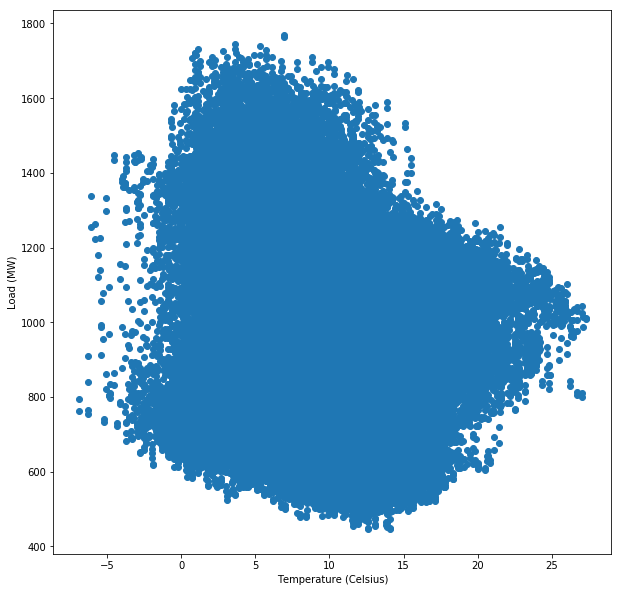

In [4]:
plt.figure(figsize=(10,10))
plt.scatter(df['Temperature'], df['Load'])
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Load (MW)')
plt.savefig("Temperature vs Load.svg", format="svg")
plt.savefig("Temperature vs Load.png", format="png")

In [5]:
df['Date_No_Time'] = df['Date'].dt.date
new_df = df.groupby(['Date_No_Time'])
mean_temp = new_df.apply(lambda x: x.Load.mean())
df_to_plot = pd.DataFrame()
df_to_plot['Date'] = mean_temp.index
df_to_plot['Mean Load'] = mean_temp.values

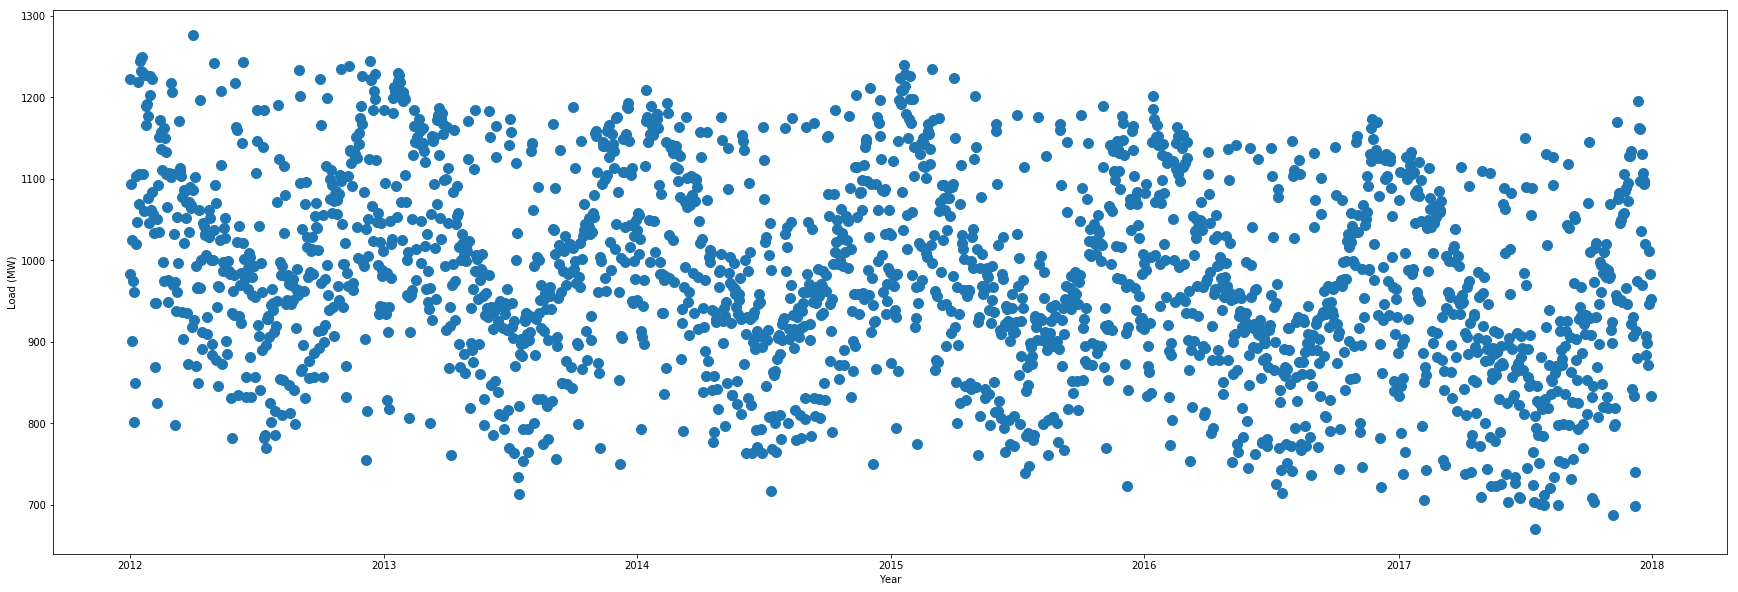

In [9]:
plt.figure(figsize=(30,10))
plt.plot_date(df_to_plot['Date'], df_to_plot['Mean Load'], markersize=10)
plt.ylabel('Load (MW)')
plt.xlabel('Year')
plt.savefig("Averaged_Load.svg", format="svg", bbox_inches='tight')
plt.savefig("Averaged_Load.png", format="png", bbox_inches='tight')

Text(0.5, 69.0, 'Year')

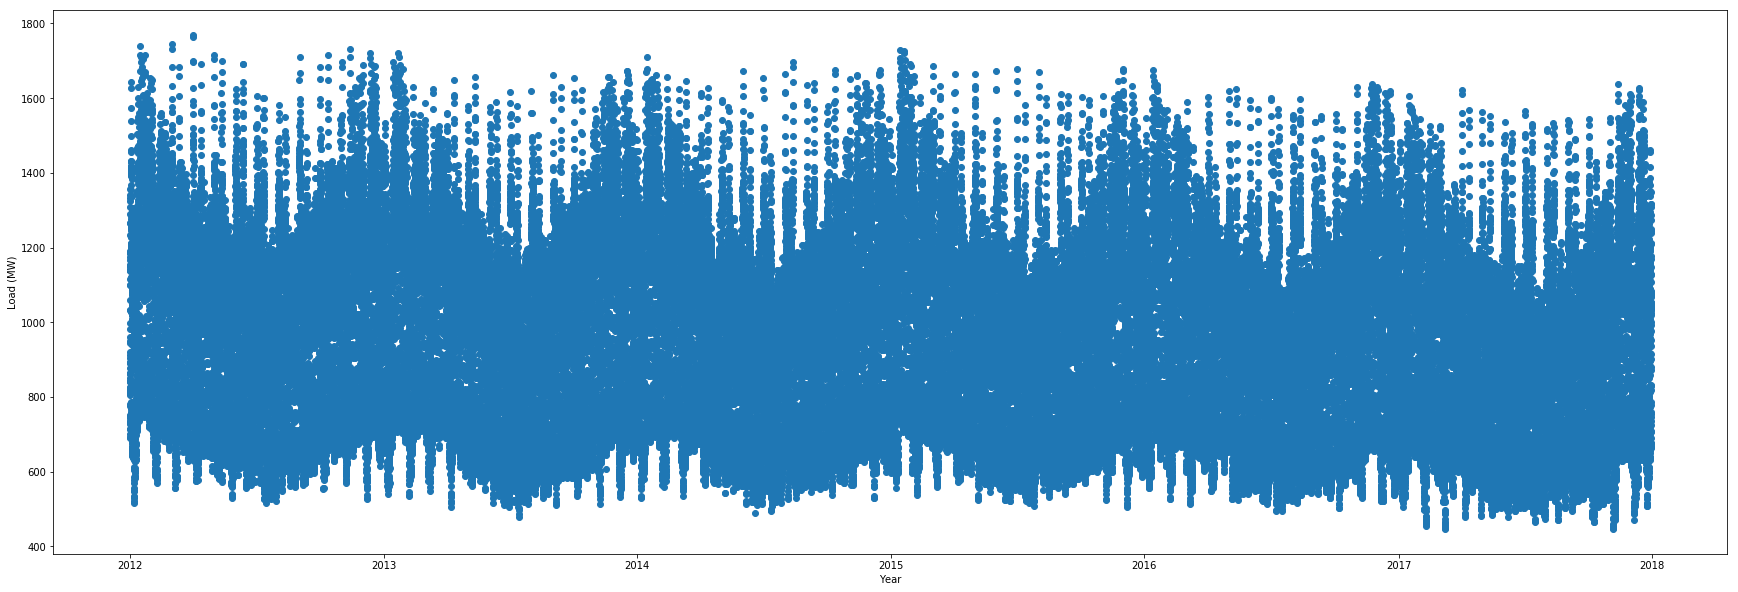

In [10]:
plt.figure(figsize=(30,10))
plt.plot_date(df['Date'], df['Load'])
plt.savefig("Load.svg", format="svg")
plt.savefig("Load.png", format="png")
plt.ylabel('Load (MW)')
plt.xlabel('Year')

Text(0.5, 69.0, 'Year')

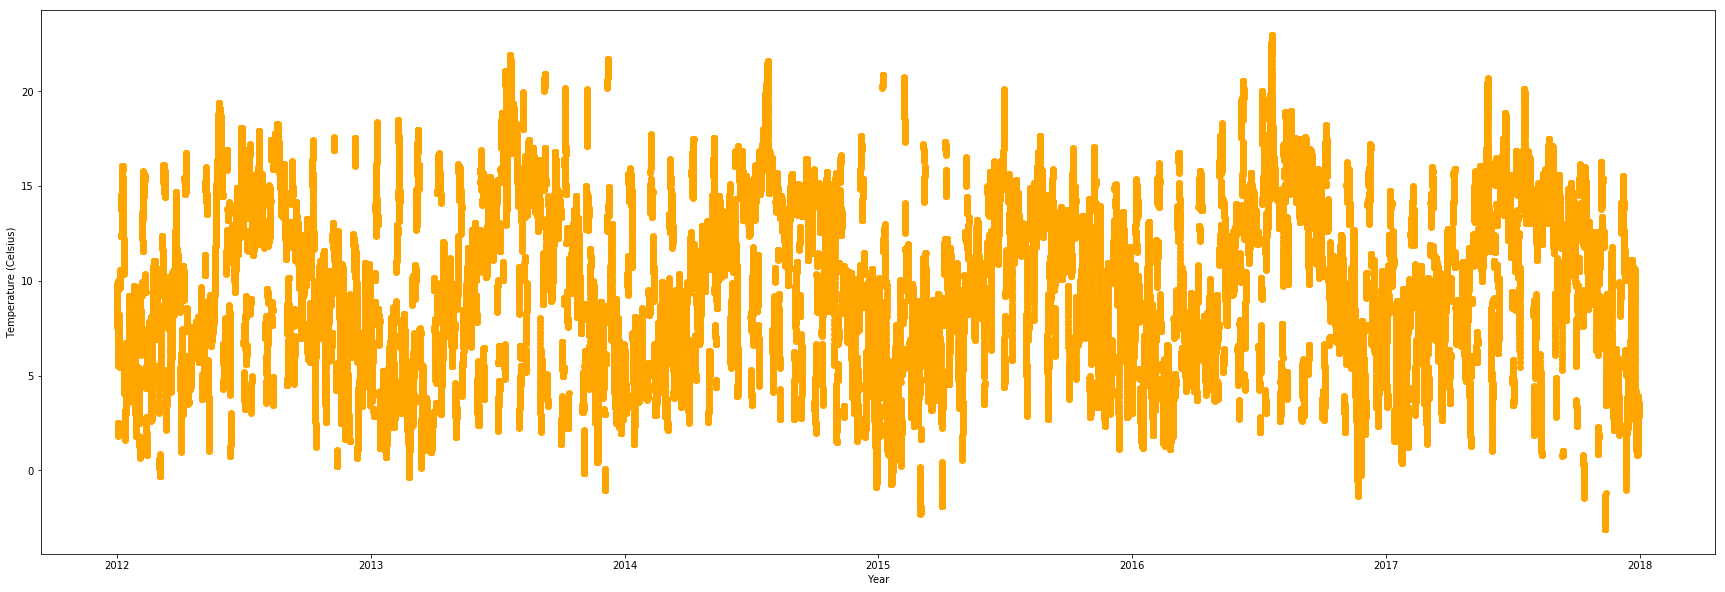

In [11]:
plt.figure(figsize=(30,10))
plt.plot_date(df['Date'], df['Temperature over 24hrs'], color='orange')
plt.savefig("Temperature.svg", format="svg")
plt.savefig("Temperature.png", format="png")
plt.ylabel('Temperature (Celsius)')
plt.xlabel('Year')

In [12]:
df['Date_No_Time'] = df['Date'].dt.date
new_df = df.groupby(['Date_No_Time'])
mean_temp = new_df.apply(lambda x: x.Temperature.mean())
df_to_plot = pd.DataFrame()
df_to_plot['Date'] = mean_temp.index
df_to_plot['Mean Temp'] = mean_temp.values

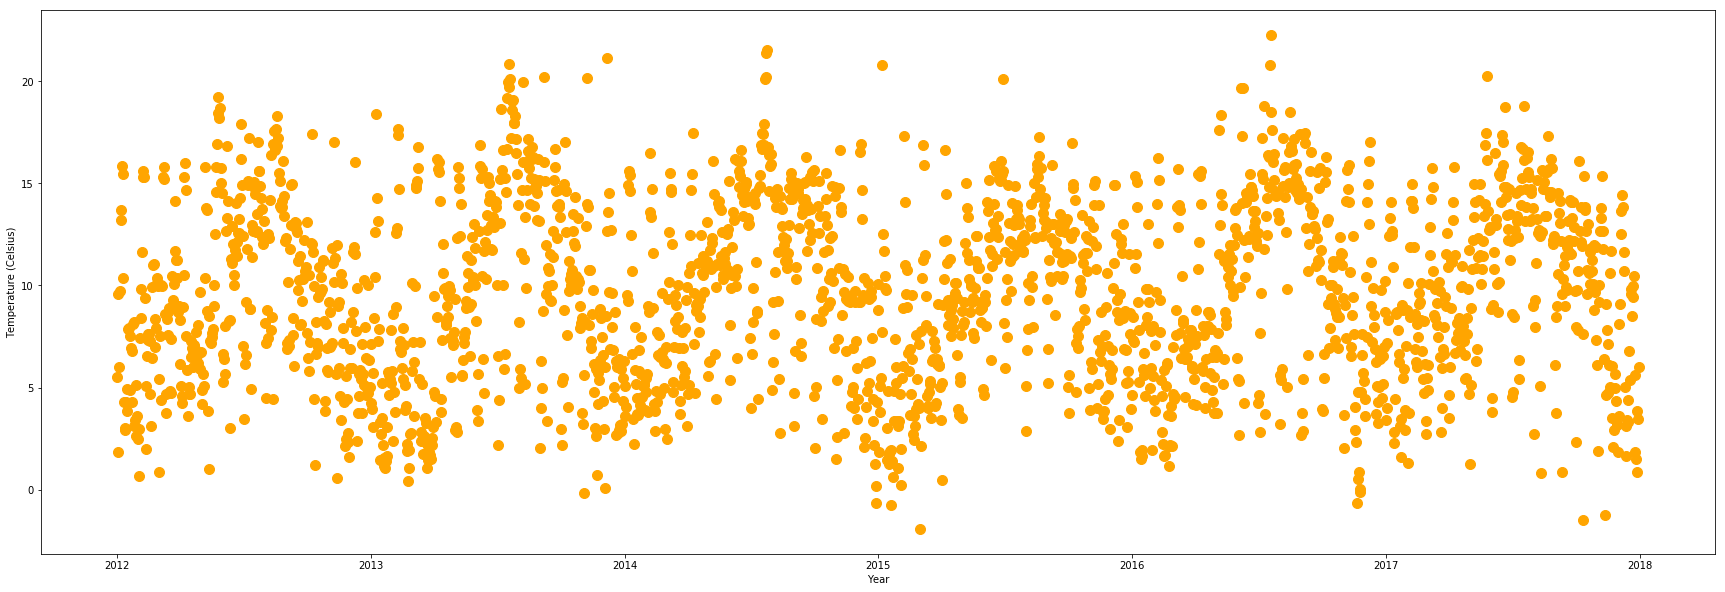

In [13]:
plt.figure(figsize=(30,10))
plt.plot_date(df_to_plot['Date'], df_to_plot['Mean Temp'], color='orange', markersize=10)
plt.ylabel('Temperature (Celsius)')
plt.xlabel('Year')
plt.savefig("Averaged_Temperature.svg", format="svg", bbox_inches='tight')
plt.savefig("Averaged_Temperature.png", format="png", bbox_inches='tight')

In [11]:
def add_datepart(df, fldname, drop=True, time=False):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Quarter', 'Hour', 'Minute', 'Day', 'Dayofweek', 'Dayofyear']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: df.drop(fldname, axis=1, inplace=True)
        

In [12]:
add_datepart(df, 'Date', drop=False)

In [26]:
df.columns

Index(['Date', 'Load', 'Temperature', 'Temperature-6hrs', 'Temperature-12hrs',
       'Temperature-18hrs', 'Temperature-24hrs', 'Temperature-36hrs',
       'Temperature-48hrs', 'Temperature-72hrs', 'Temperature-96hrs',
       'Temperature over 6hrs', 'Temperature over 12hrs',
       'Temperature over 18hrs', 'Temperature over 24hrs',
       'Temperature over 36hrs', 'Temperature over 48hrs',
       'Temperature over 72hrs', 'Temperature over 96hrs', 'Wind speed',
       'Wind speed^2', 'Wind speed^3', 'Wind direction', 'Cloud height',
       'Sun duration', 'Visibility', 'Humidity',
       'Sun duration*potential solar irradiance', 'Binary indicator sunny day',
       'Binary indicator windy day', 'Potential solar irradiance', 'Weekday',
       'Yearly cycle (sine wave)', 'Yearly cycle (cosine wave)',
       'Daily cycle (sine wave)', 'Daily cycle (cosine wave)',
       'Holiday_Alternate', 'Date_No_Time', 'Year', 'Month', 'Week', 'Quarter',
       'Hour', 'Minute', 'Day', 'Dayofweek',

Monday -0.10319407054155898
Tuesday -0.07225611448429155
Wednesday -0.0985988532356549
Thursday -0.11203463620232883
Friday -0.13620148041546756
Saturday -0.14128363350150142
Sunday -0.10413385350519205


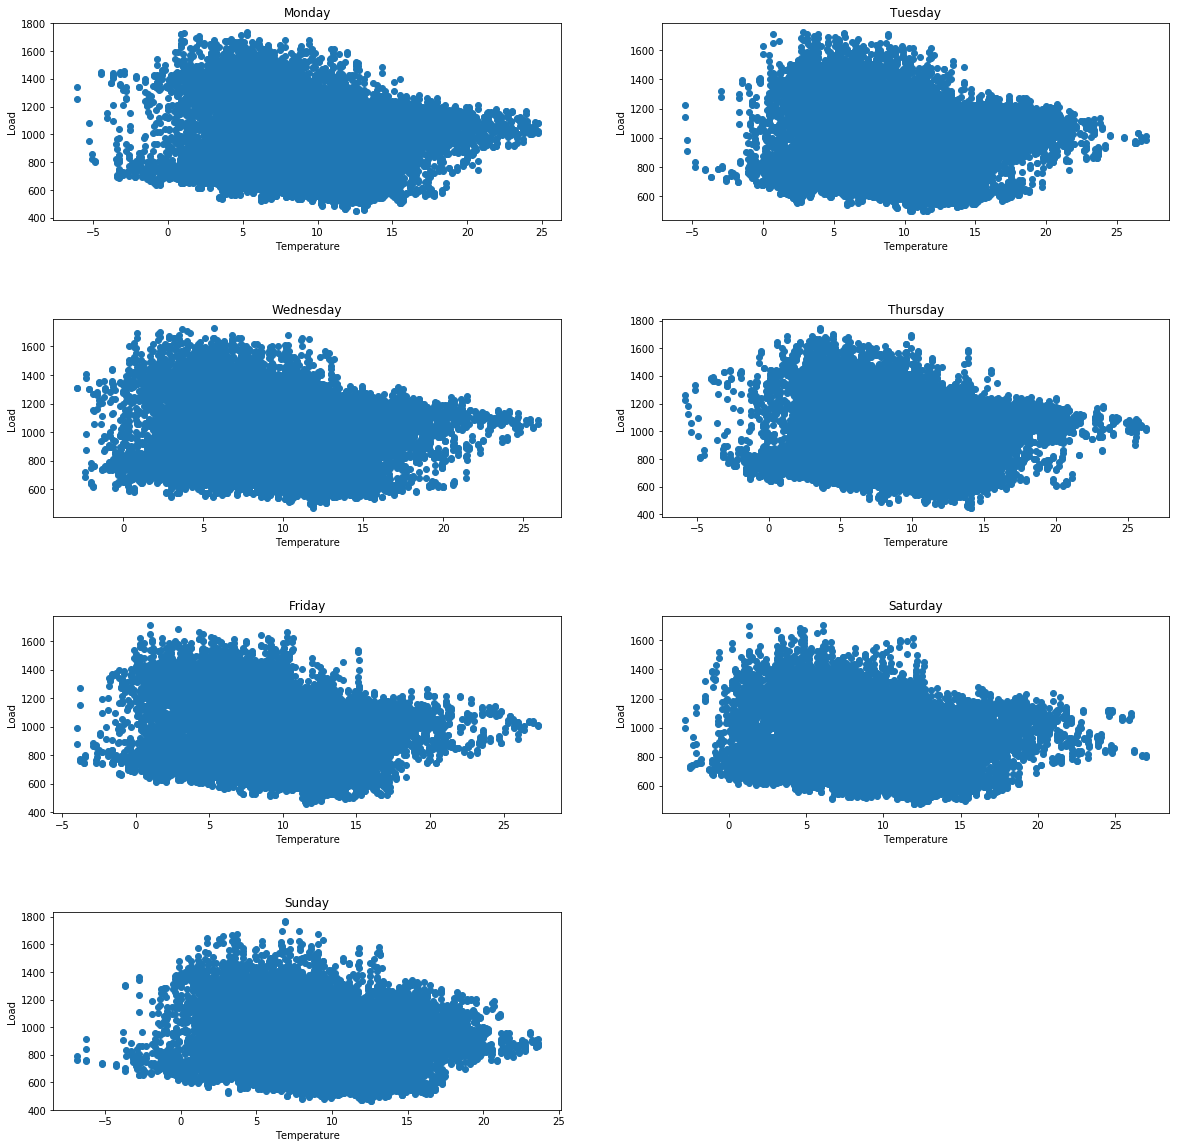

In [13]:
plt.figure(figsize=(20,20))

for i in range(0, 7):
    plt.subplot(4, 2, i+1)
    specificday = df[df['Dayofweek'] == i]
    plt.scatter(specificday['Temperature'], specificday['Load'])
    plt.title(calendar.day_name[i])
    plt.xlabel('Temperature')
    plt.ylabel('Load')
    specificday_correlation = specificday.corr()['Load']['Temperature']
    print(F'{calendar.day_name[i]} {specificday_correlation}')
    
plt.subplots_adjust(hspace = 0.5)

Friday has a change in pattern - highest temps don't decrease load as much as other days.

Mondays have the weakest correlation between temperature and load. Friday, Saturday and Sunday have a stronger correlation.

In [14]:
plt.figure(figsize=(20,20))

hourlycorrelation = pd.DataFrame(columns=['Hour', 'Correlation'])
for i in range(0, 24):
    specifichour = df[(df['Hour'] == i) & (df['Minute'] == 0)]
    specifichalfhour =  df[(df['Hour'] == i) & (df['Minute'] == 30)]
    specifichourcorrelation = specifichour.corr()['Load']['Temperature']
    specifichalfhourcorrelation = specifichalfhour.corr()['Load']['Temperature']
    hourlycorrelation = hourlycorrelation.append({'Hour': datetime(2015, 1, 1, i, 0), 'Correlation': specifichourcorrelation}, ignore_index=True)
    hourlycorrelation = hourlycorrelation.append({'Hour': datetime(2015, 1, 1, i, 30), 'Correlation': specifichalfhourcorrelation}, ignore_index=True)


    print (F"{i}:00 : {specifichourcorrelation}")
    print (F"{i}:30 : {specifichalfhourcorrelation}")

0:00 : -0.5608785235665437
0:30 : -0.594411106811881
1:00 : -0.6500603157374985
1:30 : -0.6590041816098687
2:00 : -0.654879831591798
2:30 : -0.6520077394913639
3:00 : -0.640506656218672
3:30 : -0.6319175269140904
4:00 : -0.615305651764889
4:30 : -0.6072129773271768
5:00 : -0.6043271813228381
5:30 : -0.5710558370699036
6:00 : -0.5079599243093478
6:30 : -0.4210712051924664
7:00 : -0.3778155890428508
7:30 : -0.35301001325515263
8:00 : -0.35296853824770635
8:30 : -0.3622683409378548
9:00 : -0.4194974855394433
9:30 : -0.4675363425256904
10:00 : -0.5315642849826048
10:30 : -0.5581393334769955
11:00 : -0.5889645710061581
11:30 : -0.608838236481578
12:00 : -0.6358050596950351
12:30 : -0.6522596150677906
13:00 : -0.6685920766236053
13:30 : -0.6556127504711198
14:00 : -0.6393849419892904
14:30 : -0.6297560164930391
15:00 : -0.621192075788642
15:30 : -0.6220527311817294
16:00 : -0.6262117452886825
16:30 : -0.6375001332527858
17:00 : -0.6644205182313729
17:30 : -0.7092995490116327
18:00 : -0.72446

<Figure size 1440x1440 with 0 Axes>

In [15]:
def make_corr_pos(row):
    return row['Correlation'] * -1
hourlycorrelation['Correlation'] = hourlycorrelation.apply(lambda row: make_corr_pos(row), axis=1)

In [16]:
    plt.figure(figsize=(30,10))
# plt.bar(hourlycorrelation['Hour'], hourlycorrelation['Correlation'])
    fig, ax = plt.subplots()
    ax.plot(hourlycorrelation.index, hourlycorrelation['Correlation'])
   # plt.title('Absolute correlation with temperature across days')
    plt.xlabel('Time')
    plt.ylabel('Absolute Correlation')
    myFmt = DateFormatter("%H:00")
    ax.xaxis.set_major_formatter(myFmt)
    plt.savefig("Absolute correlation with temperature across days.svg", format="svg")
    plt.savefig("Absolute correlation with temperature across days.png", format="png")

ValueError: Cannot convert -10 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000217132726A8> (for post_execute):


ValueError: Cannot convert -10 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

<Figure size 2160x720 with 0 Axes>

ValueError: Cannot convert -10 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

<Figure size 432x288 with 1 Axes>

18:00-20:30 in the day have a strong correlation between temperature and load. Weaker correlation at 6am-9am. 11:30-16:30 sees a slope down. 